##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Train and serve a TensorFlow model with TensorFlow Serving

[참고](https://www.tensorflow.org/tfx/guide/serving?hl=ko)

[참고](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/MobileNetV2)

[참고](https://www.tensorflow.org/tutorials/images/transfer_learning?hl=ko)

**Warning: This notebook is designed to be run in a Google Colab only**.  It installs packages on the system and requires root access.  If you want to run it in a local Jupyter notebook, please proceed with caution.

Note: You can run this example right now in a Jupyter-style notebook, no setup required!  Just click "Run in Google Colab"

<div class="devsite-table-wrapper"><table class="tfo-notebook-buttons" align="left">
<tr><td><a target="_blank" href="https://www.tensorflow.org/tfx/tutorials/serving/rest_simple">
<img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a></td>
<td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/tfx/blob/master/docs/tutorials/serving/rest_simple.ipynb">
<img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a></td>
<td><a target="_blank" href="https://github.com/tensorflow/tfx/blob/master/docs/tutorials/serving/rest_simple.ipynb">
<img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">View source on GitHub</a></td>
<td><a href="https://storage.googleapis.com/tensorflow_docs/tfx/docs/tutorials/serving/rest_simple.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td>
</tr></table></div>

This guide trains a neural network model to classify [images of clothing, like sneakers and shirts](https://github.com/zalandoresearch/fashion-mnist), saves the trained model, and then serves it with [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving).  The focus is on TensorFlow Serving, rather than the modeling and training in TensorFlow, so for a complete example which focuses on the modeling and training see the [Basic Classification example](https://github.com/tensorflow/docs/blob/master/site/en/r1/tutorials/keras/basic_classification.ipynb).

This guide uses [tf.keras](https://github.com/tensorflow/docs/blob/master/site/en/r1/guide/keras.ipynb), a high-level API to build and train models in TensorFlow.

In [1]:
from google.colab import drive

In [ ]:
drive.mount('MyDrive')

Mounted at MyDrive


In [ ]:
!ls -al ./

total 2109
-rw------- 1 root root 2158891 Jun 17 00:39 springboot.ods


In [2]:
import sys
import platform
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import subprocess

import tempfile
import json
import requests

In [ ]:
# Confirm that we're using Python 3
assert sys.version_info.major == 3, 'Oops, not running Python 3. Use Runtime > Change runtime type'

In [ ]:
# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

print("SUDO_IF_NEEDED=", SUDO_IF_NEEDED)

SUDO_IF_NEEDED= 


In [ ]:
# TensorFlow and tf.keras
print("Installing dependencies for Colab environment")
!pip install -Uq grpcio==1.26.0

Installing dependencies for Colab environment
     |████████████████████████████████| 2.4 MB 5.1 MB/s 


In [ ]:
# docs_infra: no_execute
!pip install -q requests

In [ ]:
!apt-get install net-tools

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  net-tools
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 194 kB of archives.
After this operation, 803 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 net-tools amd64 1.60+git20161116.90da8a0-1ubuntu1 [194 kB]
Fetched 194 kB in 1s (246 kB/s)
Selecting previously unselected package net-tools.
(Reading database ... 155569 files and directories currently installed.)
Preparing to unpack .../net-tools_1.60+git20161116.90da8a0-1ubuntu1_amd64.deb ...
Unpacking net-tools (1.60+git20161116.90da8a0-1ubuntu1) ...
Setting up net-tools (1.60+git20161116.90da8a0-1ubuntu1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
platform.platform()

'Linux-5.10.133+-x86_64-with-Ubuntu-18.04-bionic'

In [ ]:
!ldd --version

ldd (Ubuntu GLIBC 2.27-3ubuntu1.5) 2.27
Copyright (C) 2018 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
Written by Roland McGrath and Ulrich Drepper.


In [ ]:
print('TensorFlow version: {}'.format(tf.__version__))

TensorFlow version: 2.8.2


## Create your model

### Import the Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. You can access the Fashion MNIST directly from TensorFlow, just import and load the data.

Note: Although these are really images, they are loaded as NumPy arrays and not binary image objects.

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# scale the values to 0.0 to 1.0
train_images = train_images / 255.0
test_images = test_images / 255.0

# reshape for feeding into the model
# train_images.shape[0] is 60,000
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1) # same following code -> train_images.reshape(-1,28,28,1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\ntrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))

4431872/4422102 [==============================] - 0s 0us/step

train_images.shape: (60000, 28, 28, 1), of float64
test_images.shape: (10000, 28, 28, 1), of float64


### Train and evaluate your model

Let's use the simplest possible CNN, since we're not focused on the modeling part.

In [ ]:
model = keras.Sequential([
  keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3, 
                      strides=2, activation='relu', name='Conv1'),
  keras.layers.Flatten(),
  keras.layers.Dense(10, name='Dense')
])
model.summary()

testing = False
epochs = 1

model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(train_images, train_labels, epochs=epochs)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nTest accuracy: {}'.format(test_acc))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 13, 13, 8)         80        
                                                                 
 flatten (Flatten)           (None, 1352)              0         
                                                                 
 Dense (Dense)               (None, 10)                13530     
                                                                 
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________
313/313 [==============================] - 1s 2ms/step - loss: 0.4332 - sparse_categorical_accuracy: 0.8462

Test accuracy: 0.8461999893188477


## Save your model

To load our trained model into TensorFlow Serving we first need to save it in [SavedModel](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/saved_model) format.  This will create a protobuf file in a well-defined directory hierarchy, and will include a version number.  [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving) allows us to select which version of a model, or "servable" we want to use when we make inference requests.  Each version will be exported to a different sub-directory under the given path.

In [ ]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key

MODEL_DIR = tempfile.gettempdir()
print("MODEL_DIR=", MODEL_DIR)
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))
print("export_path=", export_path)

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

MODEL_DIR= /tmp
export_path = /tmp/1

export_path= /tmp/1



Saved model:
total 92
drwxr-xr-x 2 root root  4096 Sep 19 08:01 assets
-rw-r--r-- 1 root root  8228 Sep 19 08:01 keras_metadata.pb
-rw-r--r-- 1 root root 72131 Sep 19 08:01 saved_model.pb
drwxr-xr-x 2 root root  4096 Sep 19 08:01 variables


## Examine your saved model

We'll use the command line utility `saved_model_cli` to look at the [MetaGraphDefs](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/MetaGraphDef) (the models) and [SignatureDefs](../signature_defs) (the methods you can call) in our SavedModel.  See [this discussion of the SavedModel CLI](https://github.com/tensorflow/docs/blob/master/site/en/r1/guide/saved_model.md#cli-to-inspect-and-execute-savedmodel) in the TensorFlow Guide.

In [ ]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['Conv1_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_Conv1_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['Dense'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

Concrete Functions:
  Function Name: '__call__'
    Option #1
      Callable with:
        Argument #1
          Conv1_input

That tells us a lot about our model!  In this case we just trained our model, so we already know the inputs and outputs, but if we didn't this would be important information.  It doesn't tell us everything, like the fact that this is grayscale image data for example, but it's a great start.

## Serve your model with TensorFlow Serving

**Warning: If you are running this NOT on a Google Colab,** following cells
will install packages on the system with root access. If you want to run it in
a local Jupyter notebook, please proceed with caution.

### Add TensorFlow Serving distribution URI as a package source:

We're preparing to install TensorFlow Serving using [Aptitude](https://wiki.debian.org/Aptitude) since this Colab runs in a Debian environment.  We'll add the `tensorflow-model-server` package to the list of packages that Aptitude knows about.  Note that we're running as root.

Note: This example is running TensorFlow Serving natively, but [you can also run it in a Docker container](https://www.tensorflow.org/tfx/serving/docker), which is one of the easiest ways to get started using TensorFlow Serving.

In [ ]:
!wget 'http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-universal-2.8.0/t/tensorflow-model-server-universal/tensorflow-model-server-universal_2.8.0_all.deb'
!dpkg -i tensorflow-model-server-universal_2.8.0_all.deb

--2022-09-19 08:02:40--  http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-universal-2.8.0/t/tensorflow-model-server-universal/tensorflow-model-server-universal_2.8.0_all.deb
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.201.128, 74.125.202.128, 74.125.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.201.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 335421916 (320M) [application/x-debian-package]
Saving to: ‘tensorflow-model-server-universal_2.8.0_all.deb’

tensorflow-model-se 100%[===================>] 319.88M   280MB/s    in 1.1s    

2022-09-19 08:02:41 (280 MB/s) - ‘tensorflow-model-server-universal_2.8.0_all.deb’ saved [335421916/335421916]

Selecting previously unselected package tensorflow-model-server-universal.
(Reading database ... 155617 files and directories currently installed.)
Preparing to unpack tensorflow-model-server-universal_2.8.0_all.deb ...
Unpackin

In [ ]:
# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# !echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

# !echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | {SUDO_IF_NEEDED} tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | {SUDO_IF_NEEDED} apt-key add -

# !{SUDO_IF_NEEDED} apt update

In [ ]:
# ! tensorflow_model_server  --help

### Install TensorFlow Serving

This is all you need - one command line!

In [ ]:
# !{SUDO_IF_NEEDED} apt-get install tensorflow-model-server

### Start running TensorFlow Serving

This is where we start running TensorFlow Serving and load our model.  After it loads we can start making inference requests using REST.  There are some important parameters:

* `rest_api_port`: The port that you'll use for REST requests.
* `model_name`: You'll use this in the URL of REST requests.  It can be anything.
* `model_base_path`: This is the path to the directory where you've saved your model.


In [ ]:
print(MODEL_DIR)

/tmp


In [ ]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [ ]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=fashion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1


#### bg
해당 프로세스를 foreground가 아닌 background 작업으로 실행시키는 명령

#### nohup

리눅스, 유닉스에서 쉘스크립트파일 (*.sh)을 데몬형태로 실행시키는 프로그램

터미널 세션이 끊겨도 실행을 멈추지 않고 동작하도록 함

####2>&1 의 의미

* 0:standard input
* 1:standard output
* 2:standard error

처음 "> /dev/null" 은 표준출력을 /dev/null로 보내고 (즉, 버린다는 뜻)이고 두번째 부분인 "2>&1"은 표준에러를 표준출력이 보내진 곳과 동일한 곳으로 보낸다는 뜻이다.
1. `<`     filename   입력 방향을 바꾼다.
2. `>`     filename   출력 방향을 바꾼다.
3. `>>`   filename   출력에 덧붙인다.2>   filename   오류의 방향을 바꾼다.
4. `2>>` filename   오류의 방향을 바꾸고 덧붙인다.
5. `&>`  filename   출력과 오류를 리다이렉션 한다.
6. `>&`  filename   오류와 출력을 리다이렉션 한다.
7. `1>&2`             출력을 오류로 내보낸다.
8. `2>&1`             오류를 출력으로 내보낸다.
9. `>|`                출력을 리다이렉션 할 때 NOCLOBBER 설정을 무시한다
10. `<>`  filename  장치 파일(/dev)이면, 표준 출력, 표준 입력 등에 모두 사용한다.


In [ ]:
!ps -A

    PID TTY          TIME CMD
      1 ?        00:00:00 docker-init
      7 ?        00:00:02 node
     17 ?        00:00:00 tail
     27 ?        00:00:06 python3 <defunct>
     28 ?        00:00:00 colab-fileshim.
     41 ?        00:00:02 jupyter-noteboo
     42 ?        00:00:00 dap_multiplexer
     58 ?        00:00:18 python3
     78 ?        00:00:00 python3
    170 ?        00:00:25 node
    408 ?        00:00:00 bash
    410 ?        00:00:00 tensorflow_mode
    439 ?        00:00:00 ps


In [ ]:
!netstat -tnlp

Active Internet connections (only servers)
Proto Recv-Q Send-Q Local Address           Foreign Address         State       PID/Program name    
tcp        0      0 127.0.0.1:36241         0.0.0.0:*               LISTEN      58/python3          
tcp        0      0 127.0.0.1:47697         0.0.0.0:*               LISTEN      58/python3          
tcp        0      0 0.0.0.0:8500            0.0.0.0:*               LISTEN      410/tensorflow_mode 
tcp        0      0 0.0.0.0:8501            0.0.0.0:*               LISTEN      410/tensorflow_mode 
tcp        0      0 127.0.0.1:40885         0.0.0.0:*               LISTEN      78/python3          
tcp        0      0 127.0.0.1:39223         0.0.0.0:*               LISTEN      58/python3          
tcp        0      0 127.0.0.1:51705         0.0.0.0:*               LISTEN      58/python3          
tcp        0      0 127.0.0.1:17658         0.0.0.0:*               LISTEN      78/python3          
tcp        0      0 127.0.0.1:38651         0.0.

In [ ]:
!tail server.log

[warn] getaddrinfo: address family for nodename not supported
[evhttp_server.cc : 245] NET_LOG: Entering the event loop ...


## Make a request to your model in TensorFlow Serving

First, let's take a look at a random example from our test data.

In [ ]:
print(test_images.shape)

(10000, 28, 28, 1)


In [ ]:
def show(idx, title):
  plt.figure()
  plt.imshow(test_images[idx].reshape(28,28))
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

rando= 7129


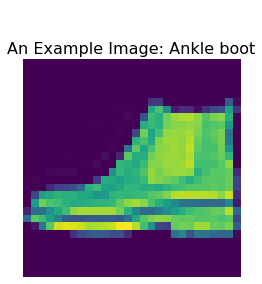

In [ ]:
rando = random.randint(0,len(test_images)-1)
print("rando=", rando)
show(rando, 'An Example Image: {}'.format(class_names[test_labels[rando]]))

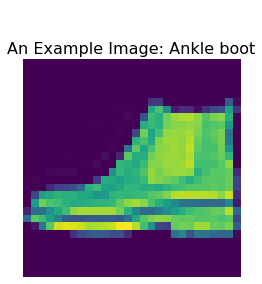

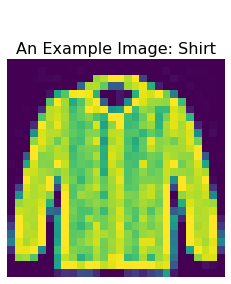

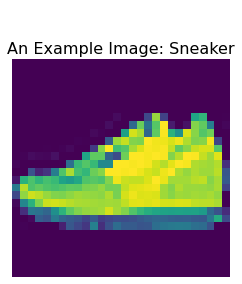

In [ ]:
for i in range(0,3):
  show(rando+i, 'An Example Image: {}'.format(class_names[test_labels[rando+i]]))

Ok, that looks interesting.  How hard is that for you to recognize? Now let's create the JSON object for a batch of  three inference requests, and see how well our model recognizes things:

In [ ]:
data = json.dumps({"signature_name": "serving_default", "instances": test_images[rando:rando+3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ...  [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]]}


In [ ]:
# data = json.dumps({"signature_name": "serving_default", "instances": test_images[3:6].tolist()})
# print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

### Make REST requests

#### Newest version of the servable

We'll send a predict request as a POST to our server's REST endpoint, and pass it three examples.  We'll ask our server to give us the latest version of our servable by not specifying a particular version.

In [ ]:
# headers = {"content-type": "application/json"}
# json_response = requests.post('http://localhost:8501/v1/models/fashion_model:predict', data=data, headers=headers)
# predictions = json.loads(json_response.text)['predictions']

# show(0, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
#   class_names[np.argmax(predictions[0])], np.argmax(predictions[0]), class_names[test_labels[0]], test_labels[0]))

3


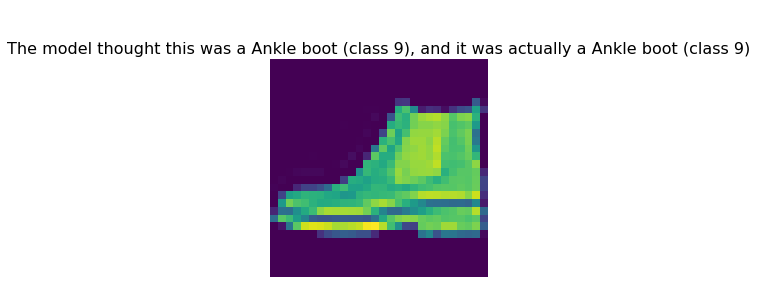

In [ ]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']
print(len(predictions))

show(rando, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
    class_names[np.argmax(predictions[0])], 
    np.argmax(predictions[0]), 
    class_names[test_labels[rando]], 
    test_labels[rando]))

#### A particular version of the servable

Now let's specify a particular version of our servable.  Since we only have one, let's select version 1.  We'll also look at all three results.

In [ ]:
# # docs_infra: no_execute
# headers = {"content-type": "application/json"}
# json_response = requests.post('http://localhost:8501/v1/models/fashion_model/versions/1:predict', data=data, headers=headers)
# predictions = json.loads(json_response.text)['predictions']

# for i in range(0,3):
#   show(i, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
#     class_names[np.argmax(predictions[i])], np.argmax(predictions[i]), class_names[test_labels[i]], test_labels[i]))

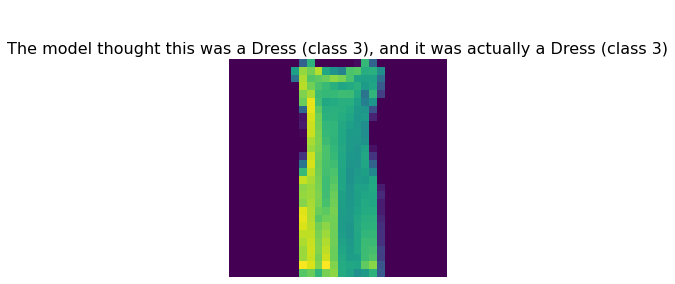

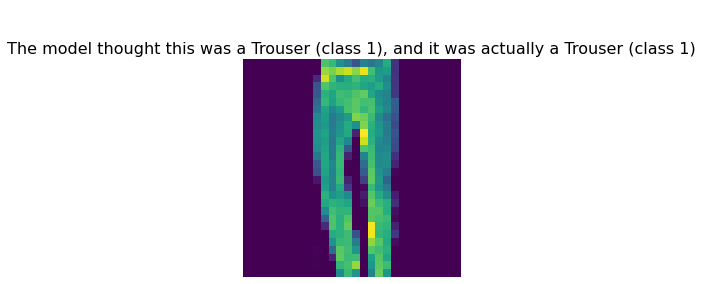

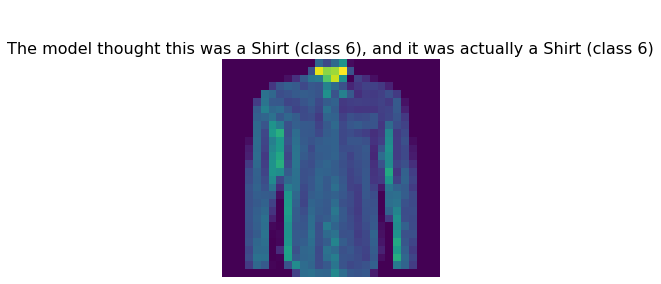

In [ ]:
# docs_infra: no_execute
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model/versions/1:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

for i in range(0,3):
  show(rando+i, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
    class_names[np.argmax(predictions[i])], np.argmax(predictions[i]), class_names[test_labels[rando+i]], test_labels[rando+i]))